## Appendice A
Sono stati sviluppati due moduli: pytsa che contiene metodi e classi per l'analisi vera e propria dell'analisi termoelastica e il modulo RoiSelect come supporto per l'interfaccia grafica interattiva. Di seguito si illustrano le funzioni di base del modulo analisi_tsa installabili tramite pip.

| **Requisiti**  | versione |
|------------|------------|
| numpy      |1.20.0|
| Numba      |0.53.1|
| matplotlib |3.4.2        |
| scipy      |1.6.3|
| sfmov      |0.2|


La libreria Numba è utilizzata per l'ottimizzazione della procedura di lockin (andattandola anche a grosse aree), quindi malgrado consigliata è presente anche la versione che non la utilizza. Analogamente per la libreria scipy necessaria per la presentazione dei dati, in funzione dei moduli per il filtraggio delle immagini.
La libreria sfmov ha lo scopo di caricarare i video in formato .sfmow, ed è stata svluppata dal Lorenzo Capponi del gruppo di misure.

-----

Si procede importando le librerie standard e il modulo analisi_tsa

In [4]:
import matplotlib.pyplot as plt
import numpy as np
# moduli sviluppati
import sys
sys.path.insert(0, f'C:../')
#
import pytsa # modulo

Definsico la frequenza di acquisizione e il percorso del file

In [5]:
fa = 120 # freq acquisizione
fr = 30 # la frequenza di carico presunta

path_npy = f'C:../video.npy'


Si inizializza quindi l'oggetto della classe TSA. L'oggetto gestisce sia il caricamento e memorizzazione del video termico che le operazioni svolte nel corso dell'analisi.
Per il caricamento è predisposto ad accettare video sia in forma di matrice numpy che come file .npy,.sfmov(tramite libreria pysfmov) che in formato .mat

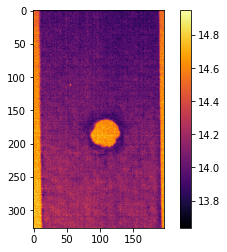

In [6]:
Analisi_30Hz = pytsa.TSA(fa,path_npy)
Analisi_30Hz.view()

Si seleziona la ROI desiderata

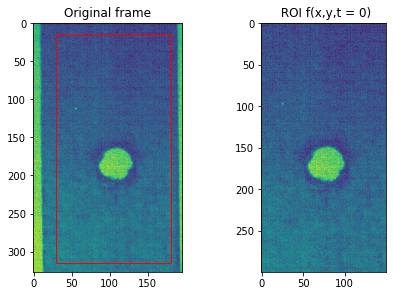

In [7]:
cordinate = (30, 15,180, 315) # (yi,xi,yf,xf)
Analisi_30Hz.set_ROI(cordinate[1],cordinate[0],cordinate[3],cordinate[2],view = True)

Si seleziona un area circolare da escludere nell'analisi. Per cordinate si intendono i vertici del rettangolo che contiene l'elisse d'interesse.

In [ ]:
#cordinate = (69, 257, 116, 304) # (yi,xi,yf,xf)
#Analisi_30Hz.set_hole(cordinate[1],cordinate[0],cordinate[3],cordinate[2])

Si procede con il Lockin nella frequenza di carico presunta (fr) e l'angolo di sfasamento (phase_offset)

* lockin fr = 30


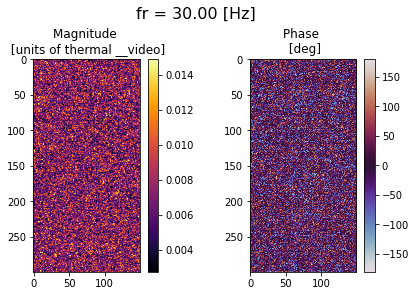

In [8]:
fr = 30 # la frequenza di carico presunta
(mappa_modulo,mappa_fase)=Analisi_30Hz.lockin(view = True,fr=fr,phase_offset=0)

E' necessario compensare la frequenza acquisita dato che per problematiche legate al banco,shaker o il generatore di segnali in ingresso la frequenza di acquisizione non sarà esattamente coindidente con quella predisposta.

---

Date le dimesioni in frequenza della finestra di ricerca e definita con cura una zona nel provino rappresentativa della sollecitazione, si estare un segnale di riferimento mediando il video termico nella finestra per ogni Frame. Tramite FFT mi riconduco nel dominio della frequenza, nella estraggo tutti i tutti i massimi locali. La funzione quindi seleziona il massimo e lo confronta con il valore degli altri picchi: se questi sono entro un certa proporzione dal massimo vengono selezionati. E' quindi chiesto all'utende di selezionare il picco con la quale procedere nell'analisi.

In [ ]:
df = 5
cordinate = (0,0,100,150) # (yi,xi,yf,xf)
_ = Analisi_30Hz.freq_detection(fr,cordinate[1],cordinate[0],cordinate[3],cordinate[2],df = df,view=True)

La scelta del picco è necessaria nei casi, come nell'esempio, in cui siano presenti componenti di disturbo nella finestra d'interesse oppure in cui il segnale termografico sia di entità tale da confondersi con il rumore. Ovviamente tutto ciò al netto di aver secelto correttamente la finestra di compensazione.

Dato il segnale di riferiemento è costruito digitalmente senza essere sincronizzato, la funzione di compensazione prova a ricostruire l'informazione riguardante la mappa di fase.
Sempre dalla stessa finsetra di calibrazione si estre anche l'offset di fase del segnale, prendendo come riferimento la fase ottenuta tramite lockin in ogni pixel. E' quindi importante selezionare un area priva di grossi gradienti (e quindi eventuali sfasamenti dovuti a non adiabticità) ed in fase con il carico.

In [ ]:
(mappa_modulo,mappa_fase)=Analisi_30Hz.lockin(view = True,t_lim_inf = None, t_lim_sup = None)

I livelli della color map per la mappa di fase sono impostati in
automatico, prendendo un fissato percentile dell'intera mappa nel definirne i limiti.
Si procede con il salvataggio delle mappe di modulo e fase e con la
visualizzazione del contour plot della mappa di modulo

In [ ]:
path = f'C:/Users/Rodo/Dropbox/Il mio PC (LAPTOP-SA2HR7TC)/Desktop/Tesi/Dati/'
Analisi_30Hz.save(path = path,name_file='Risultati_30Hz')
Analisi_30Hz.view_result_coutour_plot(levels=[0.002,0.004,0.006,0.008,0.0085,0.009,0.0095,0.01,0.011])

Visuliazzazione dell'andamento del modulo lungo una linea 

In [ ]:
cordinate = (10,174,90,174) # (yi,xi,yf,xf)
res_line = Analisi_30Hz.result_line(cordinate[1],cordinate[0],cordinate[3],cordinate[2],view = True)

In [ ]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt

res_line = gaussian_filter1d(res_line,0.5)

fig = plt.figure(figsize=(6.5, 8))
plt.plot(res_line,alpha=0.5)
plt.hlines(np.mean(res_line),0,len(res_line),'r',linewidth=2.8)

plt.grid(alpha=0.3)
plt.ylabel('Temperature [K]',fontsize=16)
plt.xlabel('Pixel',fontsize=16)
plt.legend(['Temperature','Temperature mean'])
fig.savefig("line_result.pdf", bbox_inches='tight')
np.save('line_result.npy',res_line)